In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

import nltk
import gensim.downloader
import re
from calendar import day_name, day_abbr, month_name, month_abbr
from collections import Counter

from sklearn import preprocessing
from sklearn.utils import class_weight
# from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

NUM = '~NUM~'
DATE = '~DATE~'
URL = '~URL~'
PAD = '~PAD~'
UNK = '~UNK~'

url_regex = '(www\.|http://|https://)\S+|\S+\.(co|org|net|info|be|gov|edu|html|jpg|jpeg|png|gif)'
date_regex = '('        + '|'.join(day_name[i] for i in range(7)) +\
             '|'        + '|'.join(day_abbr[i] for i in range(7)) +\
             ')?,?\s?(' + '|'.join(month_name[i] for i in range(1, 13)) +\
             '|'        + '|'.join(month_abbr[i] for i in range(1, 13)) +\
             ")\s[0-9]{1,2}(st|nd|rd|th)?(,?\s'?[0-9]{2,4})?"

stopwords = nltk.corpus.stopwords.words('english')

PERCENT_TEST = 0.075
PERCENT_VAL  = 0.075

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

In [3]:
%%time
EMBED_SIZE = 300
google300 = gensim.downloader.load('word2vec-google-news-300')
S = Counter()
C = Counter()
for word in google300.vocab:
    lower = word.lower()
    if lower in stopwords: continue
    S[lower] += google300[word]
    C[lower] += 1
google300 = {w: s / c for w, s, c in zip(S.keys(), S.values(), C.values())}

CPU times: user 54.9 s, sys: 3.52 s, total: 58.4 s
Wall time: 58.9 s


In [4]:
news = pd.read_csv('fake-news/train.csv')
news = news[['title','text','label']]
news = news.dropna()
news = news.sample(frac=1, random_state=RANDOM_SEED)

In [5]:
# binarize labels
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(news.label)

test_size = int(PERCENT_TEST * len(news))

# test data
test = news.iloc[:test_size].copy(deep=True)
y_test = y[:test_size]

# training and validation data
trainval = news.iloc[test_size:].copy(deep=True)
y_trainval = y[test_size:]

# expected result of validation_split (for estimating class weights)
val_size = int(PERCENT_VAL * len(news))
tr = trainval.iloc[:-val_size]
val = trainval.iloc[-val_size:]

print(len(tr[tr.label==0]), len(tr[tr.label==1]))
print(len(val[val.label==0]), len(val[val.label==1]))
print(len(test[test.label==0]), len(test[test.label==1]))

8820 8353
771 744
796 719


In [6]:
%%time
def split_by_case(s):
    if (not s[1:].isupper()) and (not s[1:].islower()):
        for i in range(1,len(s)-1):
            if s[i-1].islower() and s[i].isupper():
                return [s[:i]] + split_by_case(s[i:])
            elif s[i].islower() and s[i+1].isupper():
                return [s[:i+1]] + split_by_case(s[i+1:])
    return [s]

def supertokenize(txt):
    txt = re.sub(date_regex, DATE, re.sub(url_regex, URL, txt))
    tokens = nltk.word_tokenize(txt)
    y = []
    for t in tokens:
        if t in '!"\'(),--./:;<?[\\]{|}“”‘’—': continue
        t = t.lower()
        if t != "n't": t = re.sub('["\']','',t)
        if t in stopwords: continue
        if t == URL:
            y.append(URL)
            continue
        if (t == DATE) or (re.sub('^[0-9]+(/[0-9]+)+$','',t) == ''):
            y.append(DATE)
            continue
        if t.isnumeric() or (t[:-2].isnumeric() and (t[-2:] in ['st','nd','rd','th'])):
            y.append(NUM)
            continue
        if t in google300:
            y.append(t)
        else:
            if t + '.' in google300:
                y.append(t + '.')
                continue
            if t.replace('.', '') in google300:
                y.append(t.replace('.', ''))
                continue
            is_found = False
            for x in split_by_case(re.sub('[^a-z]','',t)):
                if x in google300:
                    y.append(x)
                    is_found = True
            if is_found: continue
            for st in re.split('-',re.sub('[^a-z0-9\.~]','-',t)):
                for x in [st, st[:-1], st[1:], st.replace('s','z'),
                          st.replace('ou','o'), st.replace('re','er')]:
                    if x in google300:
                        y.append(x)
                        is_found = True
                        break
            if not is_found: y.append(UNK)
    return y

def supertokenizeplus(x, lab):
    global wc_all, wc_fake, wc_real
    
    y = supertokenize(x)
    
    wc_all += Counter(y)
    
    c = Counter()
    for a in y: c[a] = 1
    if lab == 1:
        wc_fake += c
    else:
        wc_real += c
    
    return y

wc_all=Counter()
wc_fake=Counter()
wc_real=Counter()
trainval['tokenized_title'] = trainval.apply(lambda x: supertokenizeplus(x.title,x.label),axis=1)
trainval['tokenized_text'] = trainval.apply(lambda x: supertokenizeplus(x.text,x.label),axis=1)

CPU times: user 7min 32s, sys: 221 ms, total: 7min 32s
Wall time: 7min 33s


In [7]:
term_freq = Counter()
total_wc_all = np.sum(list(wc_all.values()))
for k in wc_all:
    term_freq[k] = np.abs(wc_real[k] - wc_fake[k]) /\
                  np.sqrt(wc_real[k] + wc_fake[k]) + wc_all[k] / total_wc_all
thresh = term_freq.most_common(25000)[-1][1]
tokens = [k for k, v in term_freq.items() if v >= thresh]

vocab, i = {PAD: 0, DATE: 1, URL: 2, NUM: 3, UNK: 4}, 5
for w in tokens:
    if w in (PAD, DATE, URL, NUM, UNK): continue
    vocab[w] = i
    i += 1
id2word = {v:k for k,v in vocab.items()}

i, term_freq.most_common(10)

(25017,
 [('york', 74.77673517497315),
  ('times', 66.89691863505577),
  ('new', 60.5242304531954),
  ('mr.', 58.400435695200535),
  ('breitbart', 58.0914672455477),
  ('~DATE~', 46.17414029136587),
  ('s.', 44.589239319966936),
  ('u.', 43.787452149590585),
  ('ms.', 43.579232632653046),
  ('a.', 39.10241871475195)])

In [8]:
%%time
test['tokenized_title'] = test.apply(lambda x: supertokenize(x.title),axis=1)
test['tokenized_text'] = test.apply(lambda x: supertokenize(x.text),axis=1)

CPU times: user 15.8 s, sys: 16 ms, total: 15.8 s
Wall time: 15.8 s


In [9]:
def clean(text,length):
    f = [vocab[w] if w in vocab else vocab[UNK] for w in text]
    f = f[:length]
    return (length - len(f)) * [vocab[PAD]] + f
trainval['text_as_ints'] = trainval.tokenized_text.apply(clean,args=[512])
trainval['title_as_ints'] = trainval.tokenized_text.apply(clean,args=[64])
test['text_as_ints'] = test.tokenized_text.apply(clean,args=[512])
test['title_as_ints'] = test.tokenized_text.apply(clean,args=[64])

X_trainval = [np.array(trainval.text_as_ints.to_list()), np.array(trainval.title_as_ints.to_list())]
X_test = [np.array(test.text_as_ints.to_list()), np.array(test.title_as_ints.to_list())]

In [10]:
input_text = tf.keras.layers.Input(shape=[None])
input_title = tf.keras.layers.Input(shape=[None])
mask = tf.keras.layers.Lambda(lambda inputs: tf.keras.backend.not_equal(inputs, 0))
def emb():
    e = np.zeros((len(vocab),EMBED_SIZE))
    v = np.random.uniform(-1,1,EMBED_SIZE)
    for i in range(len(vocab)):
        try:
            g = google300[id2word[i]]
            e[i] = g + v * np.linalg.norm(g) / np.linalg.norm(v)
        except KeyError:
            assert i < 5, i
            if i in [1, 2, 3]: # leave UNK and PAD zero
                e[i] = v / np.linalg.norm(v)
    return tf.keras.layers.Embedding(input_dim=e.shape[0],
                                     output_dim=e.shape[1],
                                     weights=[e],
                                     trainable=False)
emb_text = emb()(input_text)
emb_title = emb()(input_title)
l1l2 = tf.keras.regularizers.L1L2(l1=1e-6,l2=2e-6)
def gru(units):
    return tf.keras.layers.GRU(units, dropout=0.2, recurrent_dropout=0.2,
                               kernel_regularizer=l1l2)
gru_text = tf.keras.layers.Bidirectional(gru(50))(emb_text,mask=mask(input_text))
gru_title = gru(50)(emb_title,mask=mask(input_title))
concat = tf.keras.layers.Concatenate()([gru_text, gru_title])
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(concat)
model = tf.keras.Model(inputs=[input_text, input_title], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7505100     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X_trainval, y_trainval, epochs=1, batch_size=64)

292/292 [==============================] - 219s 737ms/step - loss: 0.4870 - accuracy: 0.7556


In [12]:
for i in range(len(model.layers)):
    model.layers[i].trainable = False
    if i in [2, 4]:
        model.layers[i].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7505100     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X_trainval, y_trainval, epochs=1, batch_size=64)

292/292 [==============================] - 205s 689ms/step - loss: 0.1841 - accuracy: 0.9327


In [14]:
for i in range(len(model.layers)):
    model.layers[i].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7505100     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [15]:
from sklearn.utils import class_weight
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics='accuracy')
validation_split = PERCENT_VAL / (1 - PERCENT_TEST)
checkpoint_filepath = '/tmp/checkpoint_v0'
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1],
                                                  y=[w for x in y_trainval for w in x])
class_weights = {i: weight for i, weight in enumerate(class_weights)}
model.fit(
    X_trainval, y_trainval, validation_split=validation_split, epochs=10, batch_size=32,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )], class_weight=class_weights
)

Epoch 1/10
537/537 [==============================] - 397s 728ms/step - loss: 0.0635 - accuracy: 0.9816 - val_loss: 0.0369 - val_accuracy: 0.9914
Epoch 2/10
537/537 [==============================] - 387s 720ms/step - loss: 0.0214 - accuracy: 0.9971 - val_loss: 0.0450 - val_accuracy: 0.9901
Epoch 3/10
537/537 [==============================] - 387s 720ms/step - loss: 0.0140 - accuracy: 0.9992 - val_loss: 0.0509 - val_accuracy: 0.9881
Epoch 4/10
537/537 [==============================] - 402s 749ms/step - loss: 0.0111 - accuracy: 0.9996 - val_loss: 0.0497 - val_accuracy: 0.9868
Epoch 5/10
537/537 [==============================] - 411s 765ms/step - loss: 0.0087 - accuracy: 0.9999 - val_loss: 0.0638 - val_accuracy: 0.9828
Epoch 6/10
537/537 [==============================] - 403s 750ms/step - loss: 0.0080 - accuracy: 0.9999 - val_loss: 0.0523 - val_accuracy: 0.9875
Epoch 7/10
537/537 [==============================] - 403s 751ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0530 -

In [16]:
model.load_weights(checkpoint_filepath)
logits = model.predict(X_test)
most_off = np.argmax(np.abs(y_test - logits))
print(y_test[most_off], logits[most_off])
test.iloc[most_off].title, test.iloc[most_off].text

[0] [0.99925506]


('Judicial Watch: Huma Abedin Emails Show Favors for Clinton Foundation Donors',
 'Hillary Clinton emails recently discovered on Anthony Weiner’s computer revealed, among other things, that as secretary of state, she helped Clinton Foundation donors. [Clinton aide and Weiner’s wife Huma Abedin connected State Department officials to a Russian cultural organization, per a request by Clinton Foundation donor, Eddie Trump (no relation to President Trump).  According to a May 10, 2010, email obtained and published by Judicial Watch, Abedin told Doug Band, a Bill Clinton aide who formerly headed the foundation, that she “hooked up” people who recommended Trump to the “right people” at the State Department. Trump had apparently recommended that Abedin connect Russian American Foundation Vice President Rina Kirshner with people at the State Department. Abedin wrote to Kirshner on Mon, May 10, 2010, at 9:41 PM, “Hi Rina  —   wanted to connect on meeting at state department. Eddie trump passed 

In [17]:
y_pred = np.round(logits)
print(matthews_corrcoef(y_test, y_pred))
model.evaluate(X_test, y_test)

0.9338346233805878
48/48 [==============================] - 4s 90ms/step - loss: 0.1033 - accuracy: 0.9670


[0.10331257432699203, 0.9669967293739319]

In [18]:
def get_reshaped_weights(model,layer_id):
    W=np.array(model.layers[layer_id].get_weights())
    W=W.reshape(W.shape[1],W.shape[2])
    return W
text_embed = get_reshaped_weights(model,2)
title_embed = get_reshaped_weights(model,4)

<ipython-input-19-92e1c33b0327>:8: RuntimeWarning: invalid value encountered in true_divide
  cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
<ipython-input-19-92e1c33b0327>:4: RuntimeWarning: invalid value encountered in greater_equal
  n_ = np.sum(arr >= thresh)


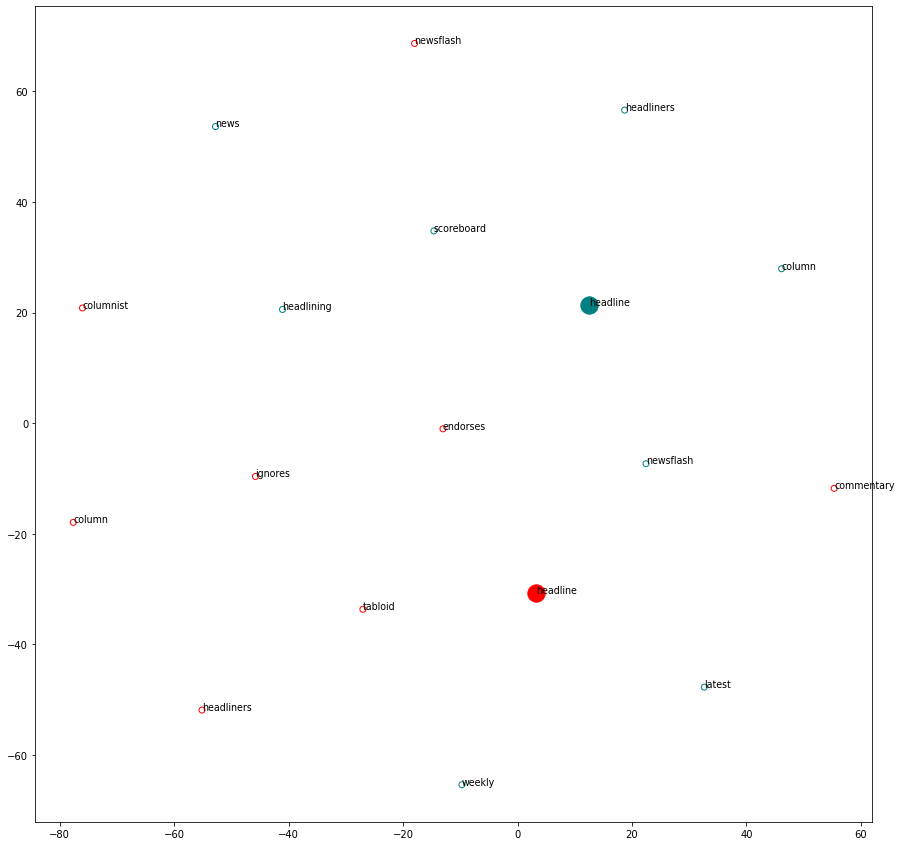

In [19]:
def get_top_n_plus_ties(arr, n):
    sorted_args = np.argsort(-arr)
    thresh = arr[sorted_args[n]]
    n_ = np.sum(arr >= thresh)
    return sorted_args[:n_]
def get_most_similar(word, W, n):
    b = W[vocab[word]]
    cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
    return get_top_n_plus_ties(cs, n)
def create_words_plot(embed1, embed2, WORD, k=9):
    ids1 = get_most_similar(WORD, embed1, k-1)
    ids2 = get_most_similar(WORD, embed2, k-1)
    words1 = [id2word[i] for i in ids1]
    words2 = [id2word[i] for i in ids2]
    v = TSNE(n_components=2,random_state=RANDOM_SEED).fit_transform(
        np.concatenate([embed1[ids1],embed2[ids2]]))
    fig = plt.figure(figsize=(15,15))
    plt.scatter(v[:k,0],v[:k,1],facecolors='none',edgecolors='teal')
    plt.scatter(v[k:,0],v[k:,1],facecolors='none',edgecolors='red')
    for i, word in enumerate(words1):
        plt.annotate(word,(v[i,0],v[i,1]),size=9.5)
        if word == WORD:
            plt.scatter(v[i,0],v[i,1],c='teal',s=300)
    for i, word in enumerate(words2):
        plt.annotate(word,(v[i+k,0],v[i+k,1]),size=9.5)
        if word == WORD:
            plt.scatter(v[i+k,0],v[i+k,1],c='red',s=300)
create_words_plot(text_embed,title_embed,'headline')